In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv' , 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Skd499@kp',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/KIIT/Desktop/dataset/ecommerce/dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Skd499@kp",
                            database = "ecommerce")

cur = db.cursor()


### List all uniques cities where customers are located.

In [79]:
query = """select distinct(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### Count the number of orders placed in 2017.

In [9]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are : " , data[0][0]

('total orders placed in 2017 are : ', 45101)

### Find the total sales per category.

In [15]:
query = """select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns=["Category" , "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### Calculate the percentage of orders that were paid in installments.

In [23]:
query = """select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that are paid in installments is :" ,data[0][0]

('The percentage of orders that are paid in installments is :',
 Decimal('99.9981'))

### Count the number of customers from each state. 

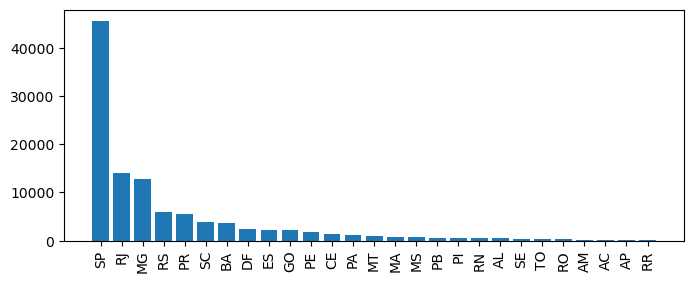

In [37]:
query = """select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["State" , "Customer_count"])
df = df.sort_values(by = 'Customer_count',ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df['State'] , df['Customer_count'])

plt.xticks(rotation = 90)
plt.show()

### Calculate the number of orders per month in 2018.

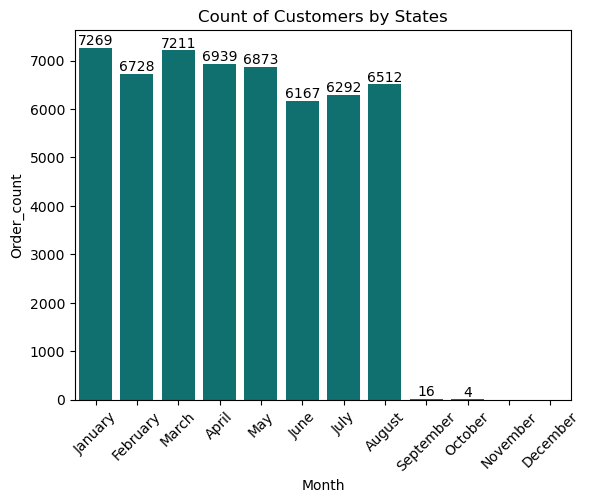

In [56]:
 

df = pd.DataFrame(data , columns=["Month" , "Order_count"])
o = ["January" , "February" , "March" , "April" , "May" , "June" , "July" , "August" , "September" , "October" ,"November" , "December"]
ax = sns.barplot(x = df["Month"] , y = df["Order_count"] , data = df , order = o, color = "Teal")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Customers by States")

plt.show()

### Find the average number of products per order, grouped by customer city.

In [71]:
query = """with count_per_order as (select orders.order_id , orders.customer_id , count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)  

select customers.customer_city , round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

# in first part - no. of products in each order by each customer
# in second part we have grouped it on the basis of customer_city

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer_City" , "Average products per order"])
df.head(10 )

,Customer_City,Average products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


In [ ]:
### Calculate the percentage of total revenue contributed by each product category.

In [77]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc
"""

cur.execute(query)

data = cur.fetchall()
data

[('BED TABLE BATH', 10.7),
 ('HEALTH BEAUTY', 10.35),
 ('COMPUTER ACCESSORIES', 9.9),
 ('FURNITURE DECORATION', 8.93),
 ('WATCHES PRESENT', 8.93),
 ('SPORT LEISURE', 8.7),
 ('HOUSEWARES', 6.84),
 ('AUTOMOTIVE', 5.32),
 ('GARDEN TOOLS', 5.24),
 ('COOL STUFF', 4.87),
 ('FURNITURE OFFICE', 4.04),
 ('TOYS', 3.87),
 ('BABIES', 3.37),
 ('PERFUMERY', 3.17),
 ('TELEPHONY', 3.04),
 ('STATIONARY STORE', 1.98),
 ('PET SHOP', 1.94),
 ('PCS', 1.74),
 ('ELECTRONICS', 1.62),
 (None, 1.58),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 1.51),
 ('MUSICAL INSTRUMENTS', 1.46),
 ('ELECTROSTILE', 1.41),
 ('FASHION BAGS AND ACCESSORIES', 1.36),
 ('FIXED TELEPHONY', 1.29),
 ('GAMES CONSOLES', 1.22),
 ('BAGS ACCESSORIES', 1.17),
 ('CASA CONSTRUCAO', 0.85),
 ('ROOM FURNITURE', 0.85),
 ('ELECTRICES 2', 0.78),
 ('AGRO INDUSTRIA E COMERCIO', 0.74),
 ('HOME APPLIANCES', 0.6),
 ('CLIMATIZATION', 0.57),
 ('HOUSE COMFORT', 0.53),
 ('FURNITURE KITCHEN SERVICE AREA DINNER AND GARDEN', 0.47),
 ('CONSTRUCTION TOOLS ILLUMINATION',